In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.ensemble import ExtraTreesClassifier, RandomTreesEmbedding, RandomForestClassifier 
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split 
import xgboost as xgb
from sklearn.metrics import  roc_auc_score


# path = 'porto-seguro-safe-driver-prediction/train'
warnings.filterwarnings("ignore")
train_data = pd.read_csv('porto-seguro-safe-driver-prediction/train.csv')
test = pd.read_csv('porto-seguro-safe-driver-prediction/test.csv')
# sample = pd.read_csv('porto-seguro-safe-driver-prediction/sample_submission.csv')
# train = train_data.sample(frac = 0.1, random_state = 200)
train = train_data
# train.drop('id', axis = 1, inplace = True)
pd.set_option('display.max_columns', 100)


In [6]:
test.shape

(892816, 58)

1)Problem Description:

Car insurance rates are based on predictions of the probability that a policy holder will file a claim. As such, it is important that insurers are able to accurately predict claim probability. Inaccuracies in claim prediction results in higher rates which systematically penalizes "good" drivers for the mistakes of "bad" drivers. The objective of this project is to build a model that predicts the probability that a driver will initiate an auto insurance claim within the next year.

The data is obtained from the Kaggle Porto Seguro's Safe Driver Predition competition [2]. The test and train datasets contains features that are labeled (e.g., ind, reg, car, calc) to group them by type. They are also labeled by postfix bin to indicate binary features and cat to indicate categorical features. Features that are not labeled by this postfix are either continuous or ordinal. Missing features were given a value of -1. The target column denotes whether a claim was filed for a particular policy holder. A detailed summary of the dataset can be found at [2].

2)EDA: Following a procedure shown in  [1], I stored meta-information about the variables from the dataset to help make it easier to select specific variables. The variables were sorted by the following metadata:

role: input, ID, target
level: nominal, interval, ordinal, binary
keep: True or False
dtype: int, float, str


In [3]:
#adding metadata to allow for easier data manipulation
data = []
for f in train.columns:
    # Defining the role
    if f == 'target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'
         
    # Defining the level
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f or f == 'id':
        level = 'nominal'
    elif train[f].dtype == float:
        level = 'interval'
    elif train[f].dtype == int or train[f].dtype == 'int64':
        level = 'ordinal'
#     else:
#         print(f)
        
    # Initialize keep to True for all variables except for id
    keep = True
    if f == 'id':
        keep = False
    
    # Defining the data type 
    dtype = train[f].dtype
    
    # Creating a Dict that contains all the metadata for the variable
    f_dict = {
        'varname': f,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace=True)

In [4]:
pd.DataFrame({'count' : meta.groupby(['role', 'level'])['role'].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


EDA(Continued): By comparing the total number of claims to total number of policy holders, it was found that only about 3.6% of the policy holders in the dataset file insurance claims (target = 1). This shows that this is an imbalanced binary classification problem. I chose to handle this imbalance through undersampling of policy holders that did not file claims (target = 0) such that claims represent 10% of the total insurance records.

In [5]:
claim_counts = train['target'].value_counts()
print('Percent of Claims: ', 100 * claim_counts[1]/train.shape[0], '%')

Percent of Claims:  3.6447517859182947 %


In [6]:
#Undersample target = 0
desired_apriori=0.10

# Get the indices per target value
idx_0 = train[train.target == 0].index
idx_1 = train[train.target == 1].index

# Get original number of records per target value
nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

# Calculate the undersampling rate and resulting number of records with target=0
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# Randomly select records with target=0 to get at the desired a priori
undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

# Construct list with remaining indices
idx_list = list(undersampled_idx) + list(idx_1)

# Return undersample data frame
train = train.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


In [7]:
claim_counts = train['target'].value_counts()
print('Percent of Claims: ', 100 * claim_counts[1]/train.shape[0], '%')

Percent of Claims:  10.0 %


EDA(Continued): Next, I checked for missing data values. According to the kaggle competition page [2], missing values are  represented as -1.

In [8]:
def check_missing(df):
    vars_with_missing = []
    for f in df.columns:
        missings = df[df[f] == -1][f].count()
        if missings > 0:
            vars_with_missing.append(f)
            missings_perc = missings/df.shape[0]
        
            print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))
        
    print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

check_missing(train)

Variable ps_ind_02_cat has 103 records (0.05%) with missing values
Variable ps_ind_04_cat has 51 records (0.02%) with missing values
Variable ps_ind_05_cat has 2256 records (1.04%) with missing values
Variable ps_reg_03 has 38580 records (17.78%) with missing values
Variable ps_car_01_cat has 62 records (0.03%) with missing values
Variable ps_car_02_cat has 2 records (0.00%) with missing values
Variable ps_car_03_cat has 148367 records (68.39%) with missing values
Variable ps_car_05_cat has 96026 records (44.26%) with missing values
Variable ps_car_07_cat has 4431 records (2.04%) with missing values
Variable ps_car_09_cat has 230 records (0.11%) with missing values
Variable ps_car_11 has 1 records (0.00%) with missing values
Variable ps_car_14 has 15726 records (7.25%) with missing values
In total, there are 12 variables with missing values


EDA(Continued): We see that there are 12 missing variables:

ps_car_03_cat and ps_car_05_cat are missing ~68% and ~44% of values respectively. Since there was so much missing data, I chose to drop these features rather than try to impute values. 

ps_reg_03 is continuous interval data represented by float, and is missing values for ~18% of records so I chose to impute by mean

ps_car_11 is only missing 1 record and contains ordinal data so I chose to impute by mode

ps_car_14 is continuous and missing ~7% of values so I chose to impute by mean.

The remaining variables are categorical, so I chose to leave missing data values as -1

In [9]:
# Dropping the variables with too many missing values
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train.drop(vars_to_drop, inplace=True, axis=1)
meta.loc[(vars_to_drop),'keep'] = False  # Updating the meta

# Imputing with the mean or mode
mean_imp = SimpleImputer(missing_values=-1, strategy='mean')
mode_imp = SimpleImputer(missing_values=-1, strategy='most_frequent')
train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']]).ravel()
# train['ps_car_12'] = mean_imp.fit_transform(train[['ps_car_12']]).ravel()
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_11'] = mode_imp.fit_transform(train[['ps_car_11']]).ravel()

EDA(Continued): Next, I looked at the cardinality of categorical variables. Note that ps_car_11 has a large cardinality of 104. I suspect that this should be handled in some way to reduce the number of features after one-hot encoding the categorical values. However, I did not find a good way to do this. 

In [10]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    dist_values = train[f].value_counts().shape[0]
    print('Variable {} has {} distinct values'.format(f, dist_values))

Variable ps_ind_02_cat has 5 distinct values
Variable ps_ind_04_cat has 3 distinct values
Variable ps_ind_05_cat has 8 distinct values
Variable ps_car_01_cat has 13 distinct values
Variable ps_car_02_cat has 3 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 3 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 6 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


EDA(Continued): Next, I looked at the proportion of customers with target = 1 by categorical variables. It is interesting to note that missing categorical data values can still be a good predictor of if the policy holder will file a claim. For example, over 60% of holders have a missing data value for the feature ps_ind_04.

<Figure size 432x288 with 0 Axes>

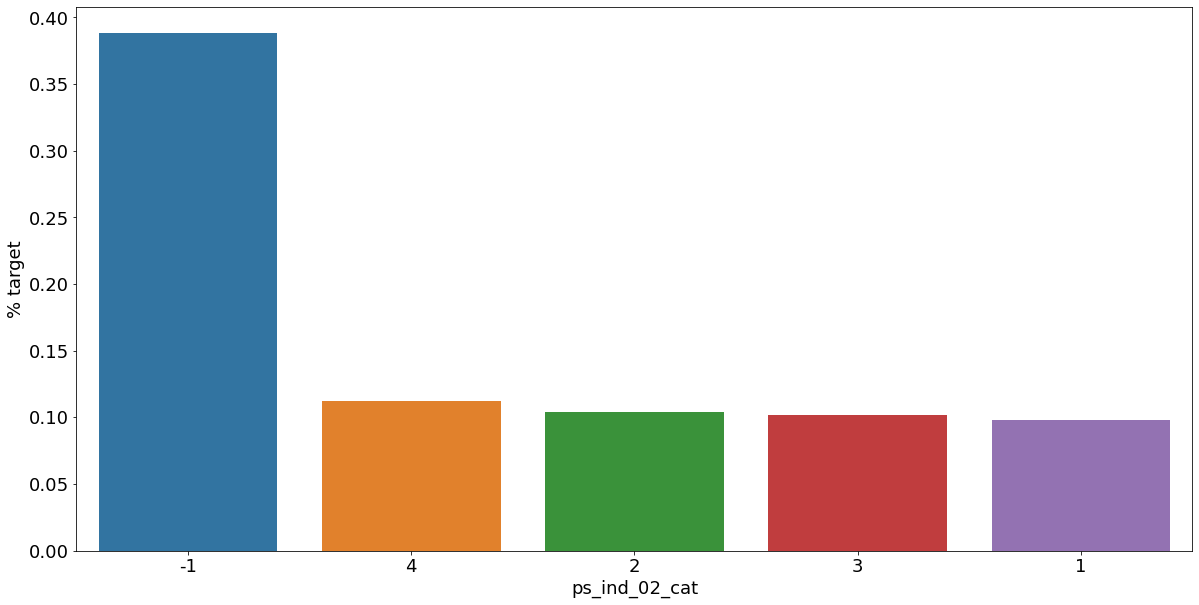

<Figure size 432x288 with 0 Axes>

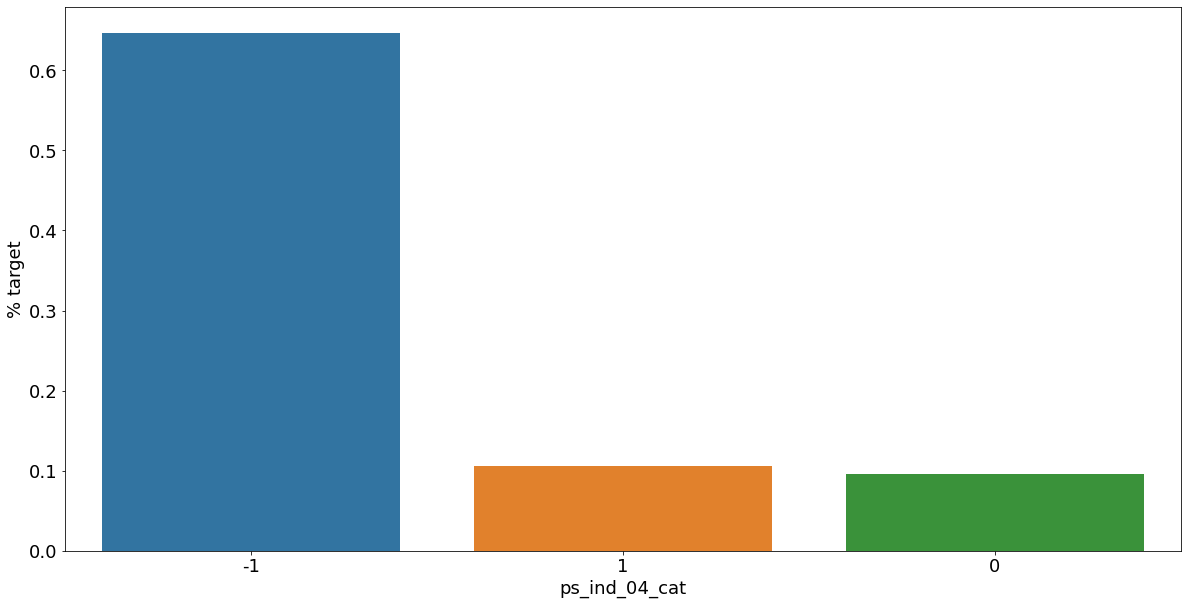

<Figure size 432x288 with 0 Axes>

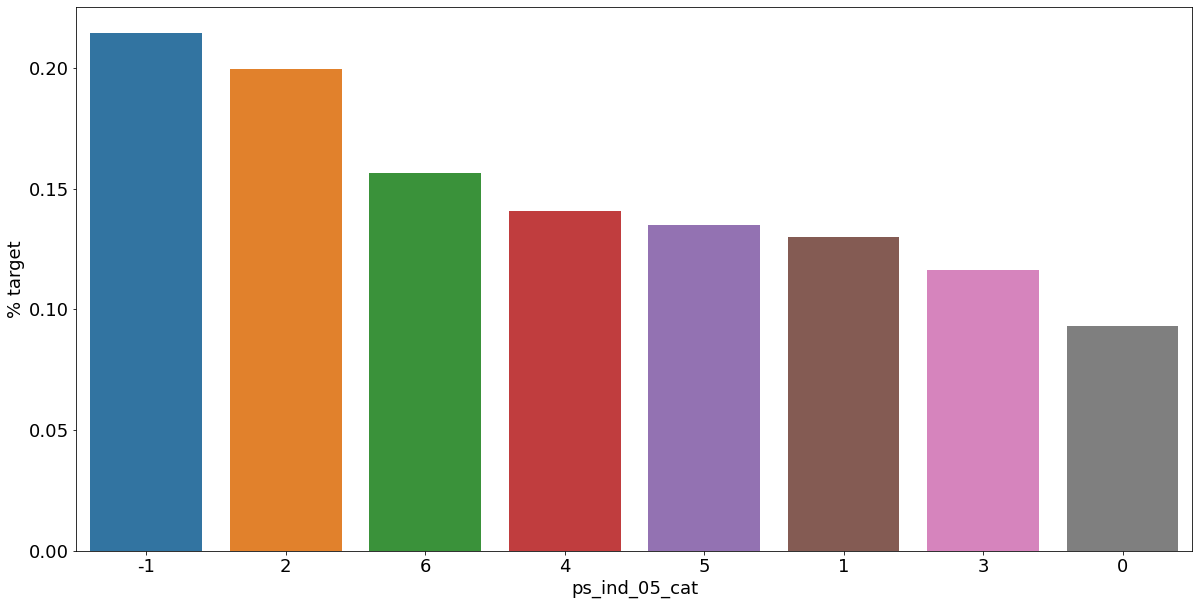

<Figure size 432x288 with 0 Axes>

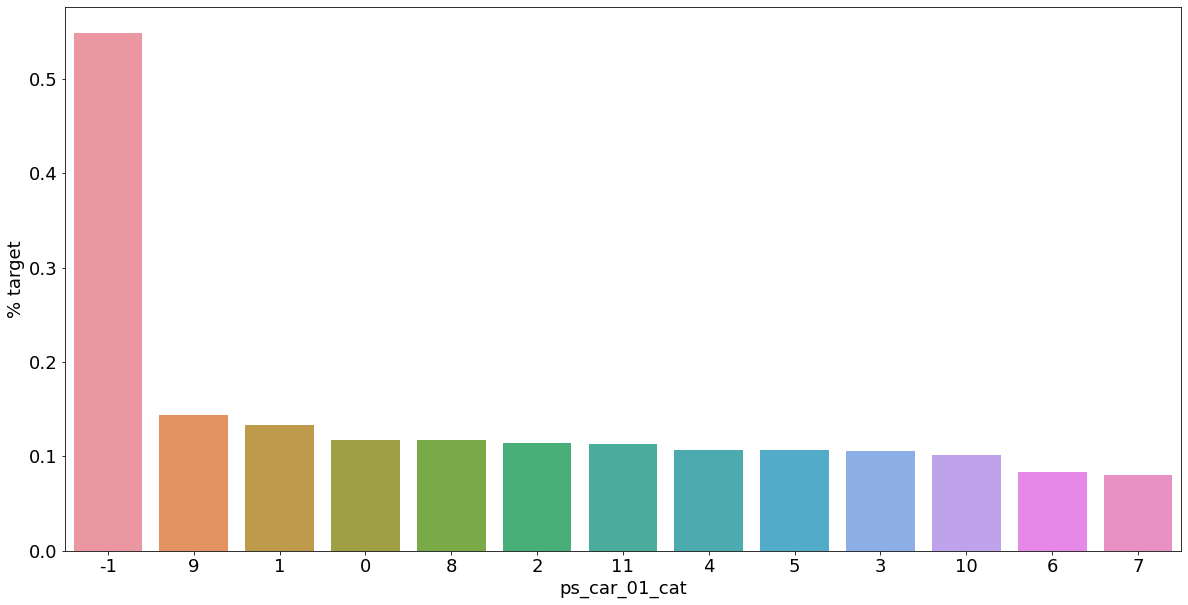

<Figure size 432x288 with 0 Axes>

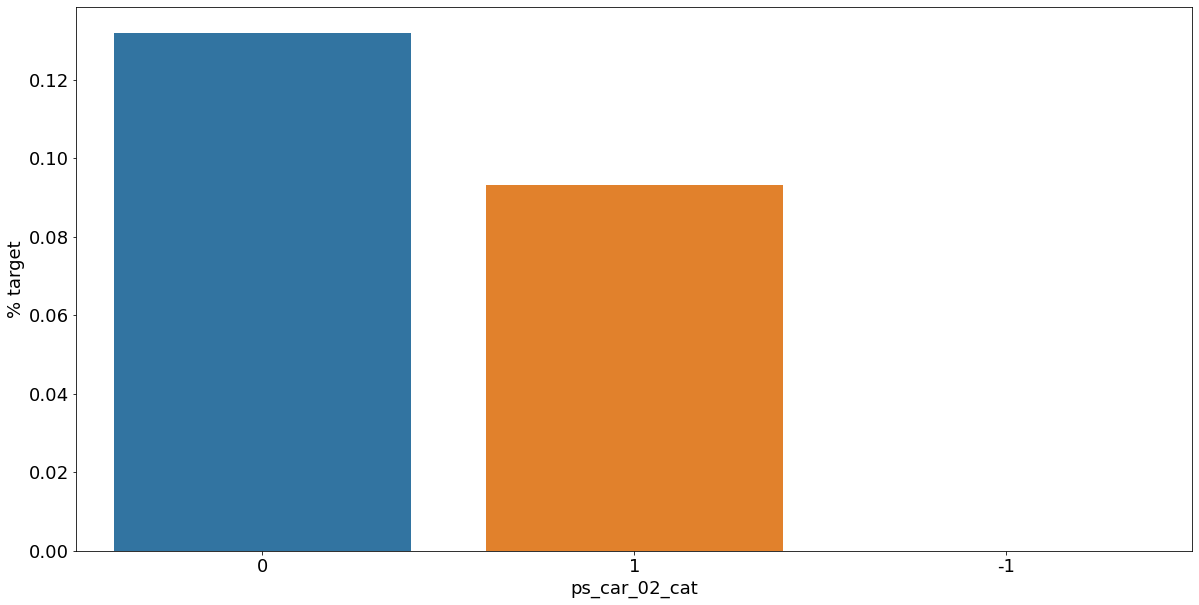

<Figure size 432x288 with 0 Axes>

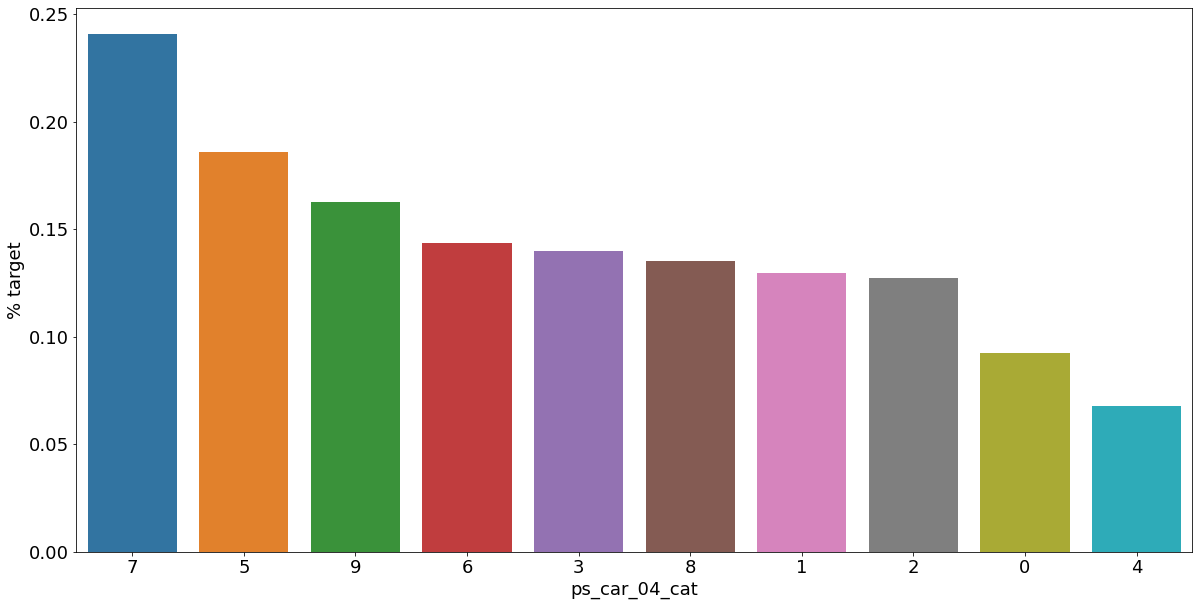

<Figure size 432x288 with 0 Axes>

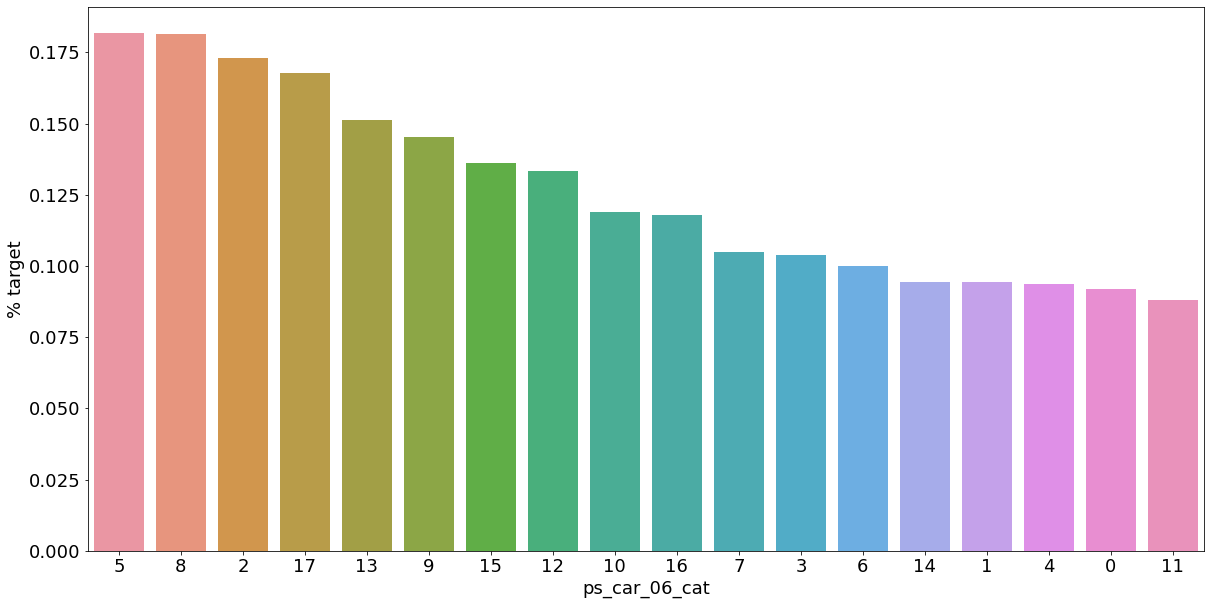

<Figure size 432x288 with 0 Axes>

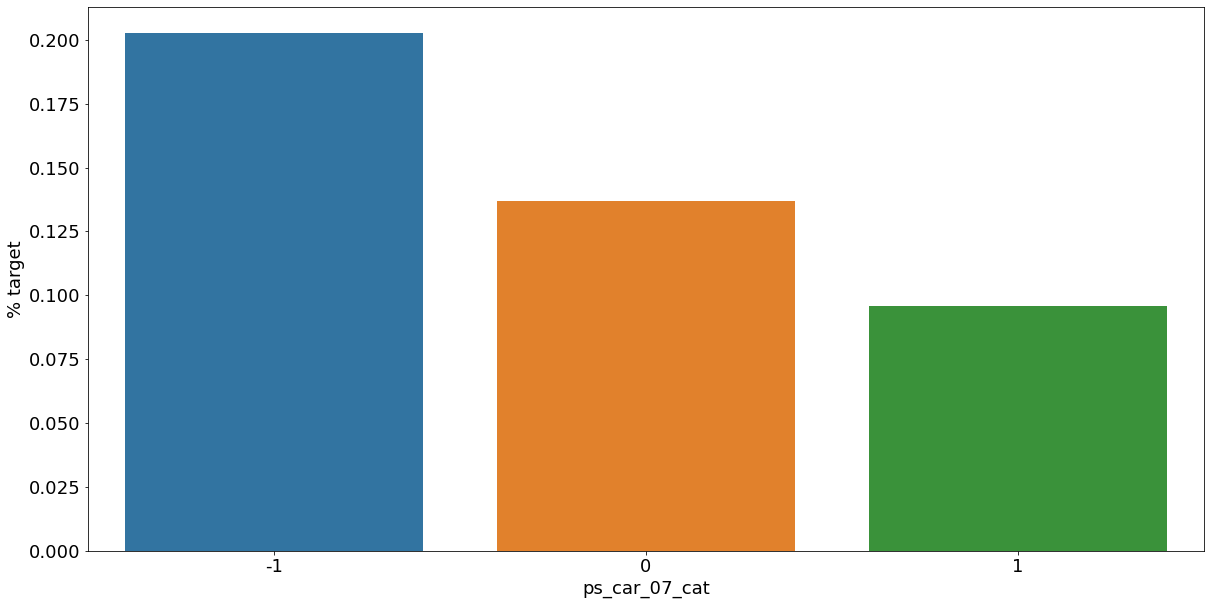

<Figure size 432x288 with 0 Axes>

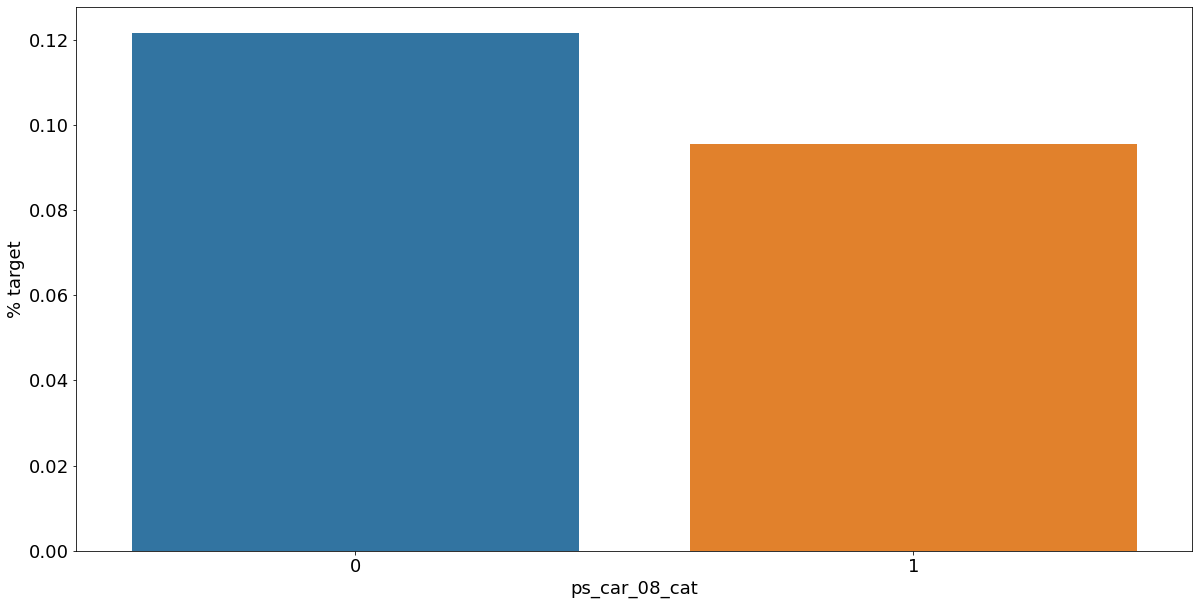

<Figure size 432x288 with 0 Axes>

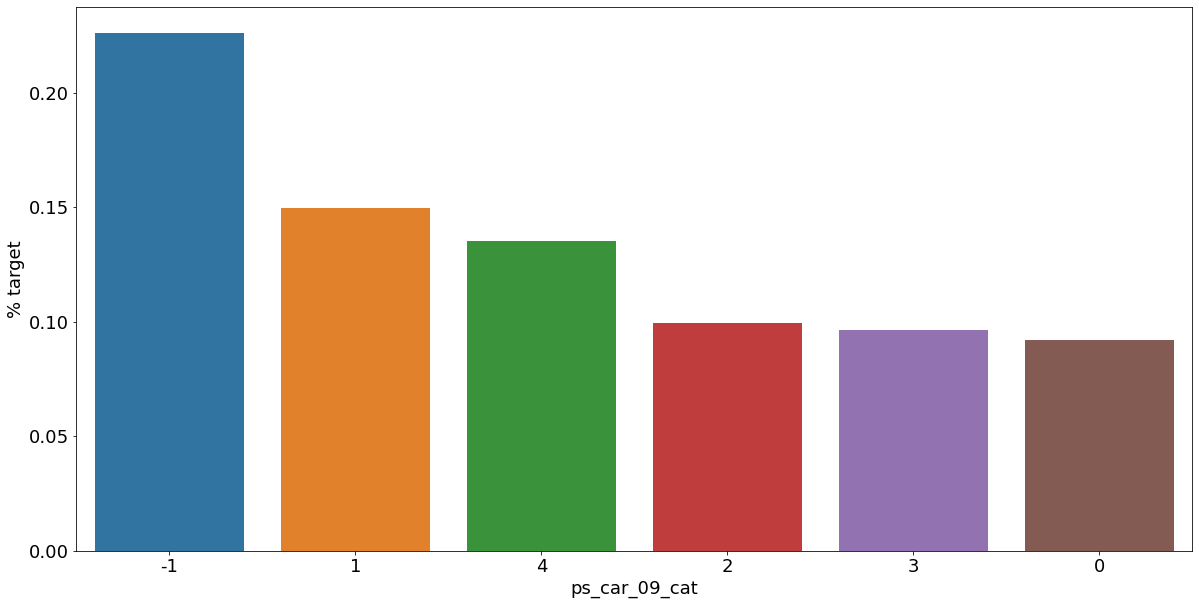

<Figure size 432x288 with 0 Axes>

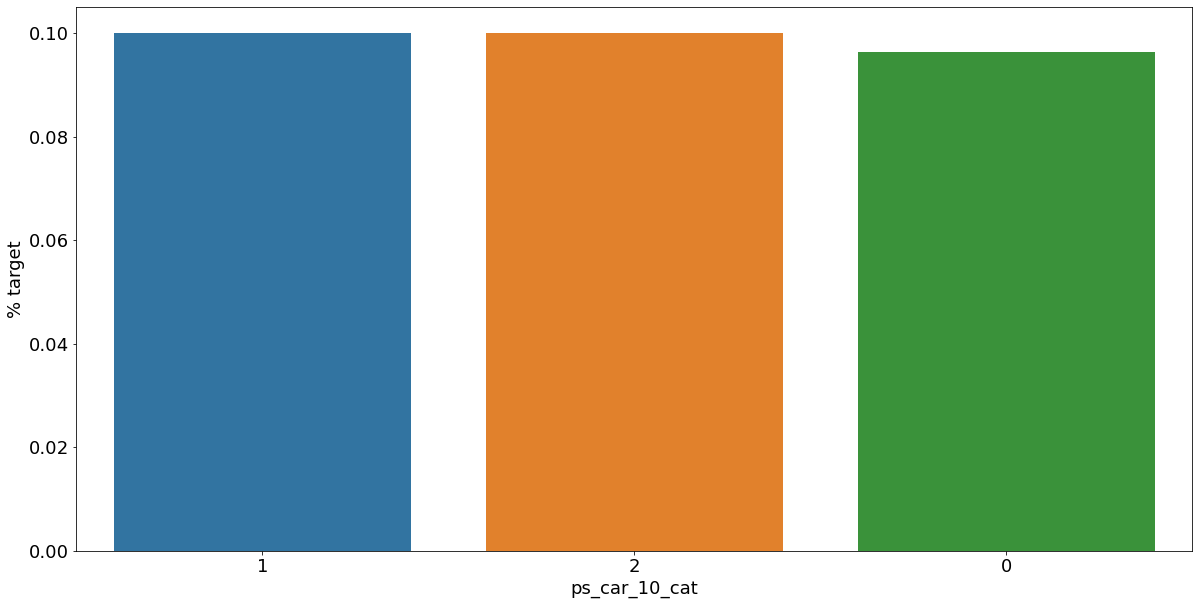

<Figure size 432x288 with 0 Axes>

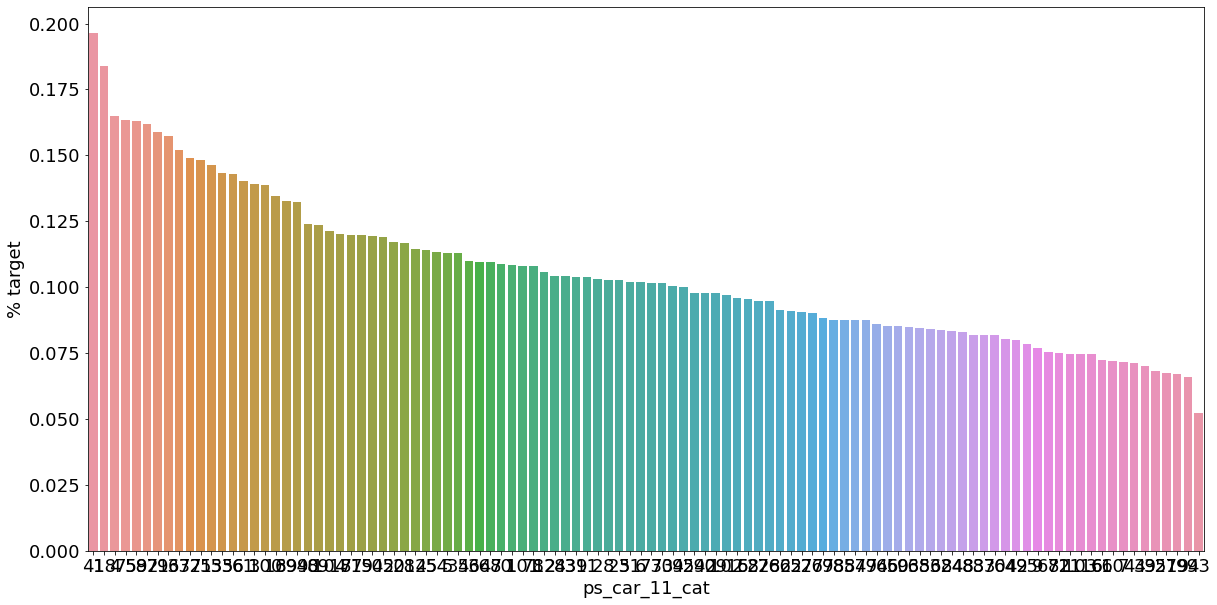

In [12]:
#Visualize Categorical Data
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    plt.figure()
    fig, ax = plt.subplots(figsize=(20,10))
    # Calculate the percentage of target=1 per category value
    cat_perc = train[[f, 'target']].groupby([f],as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    # Bar plot
    # Order the bars descending on target mean
    sns.barplot(ax=ax, x=f, y='target', data=cat_perc, order=cat_perc[f])
    plt.ylabel('% target', fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show();

EDA(continued): Next, I looked at interval variables. A heatmap was created to visualize the pairwise correlation between interval variables. It was noted that there was a strong correlation between the following variables:

ps_reg_02 and ps_reg_03 (0.7)
ps_car_12 and ps_car13 (0.67)
ps_car_12 and ps_car14 (0.58)
ps_car_13 and ps_car15 (0.67)

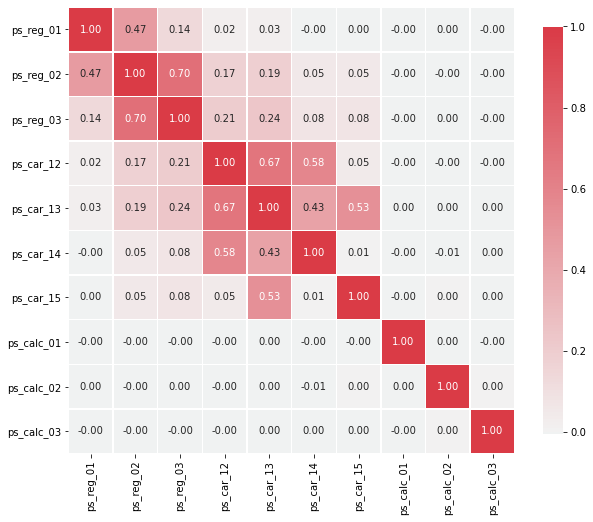

In [13]:
#Visualize Interval Data by Heatmap

def corr_heatmap(v):
    correlations = train[v].corr()

    # Create color map ranging between two colors
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show();
    
v = meta[(meta.level == 'interval') & (meta.keep)].index
corr_heatmap(v)


EDA(Continued): To visualize the linear relationship between variables with strong pairwise correlation (stated above), a pairplot was generated for each pair of variables. Note that the plots were generated using a sample of 10% of the training dataset for ease of computation and visualization. In [3], I read about a method of performing Principal COmponent Analysis (PCA) on correlated variables to reduce the number of features and improve the performance of the machine learning model. However, I decided this was not necessary since there is only 4 highly correlated variables.

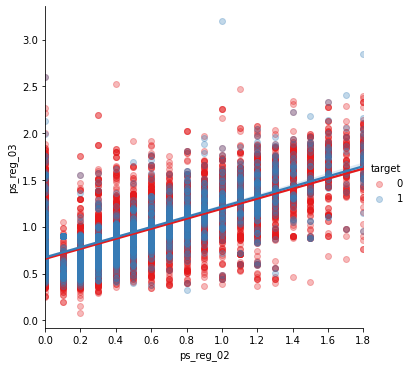

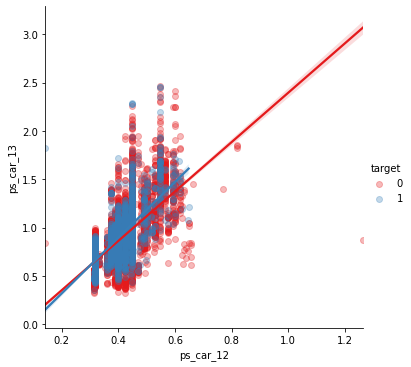

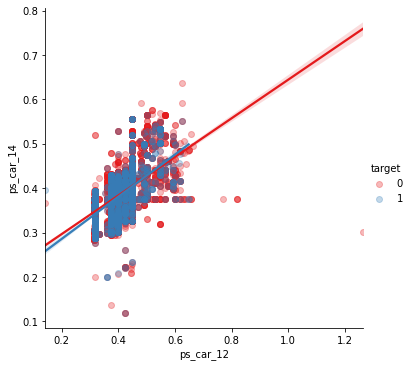

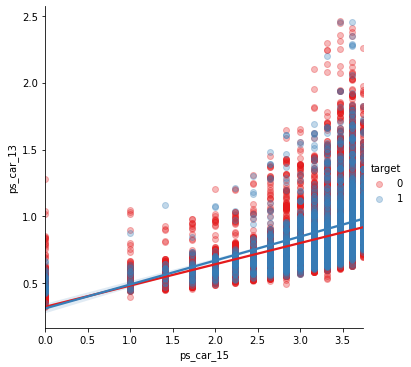

In [14]:
#use pairplot to visualize linear relationship between variables with high correlation

s = train.sample(frac = .1) #sample data for easier visualizaition

sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

sns.lmplot(x='ps_car_12', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

sns.lmplot(x='ps_car_12', y='ps_car_14', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

sns.lmplot(x='ps_car_15', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

EDA(Continued): Similar to what I did for interval variables, I generated a heatmap to visualize the pairwise correlation between ordinal data values. The heatmap shows that there is not any very strong correlations between interval data values. Better correlation might be found if I had chose to put interval data values into bins or by grouping the variables by target value, but I chose not to do this for the sake of time. 

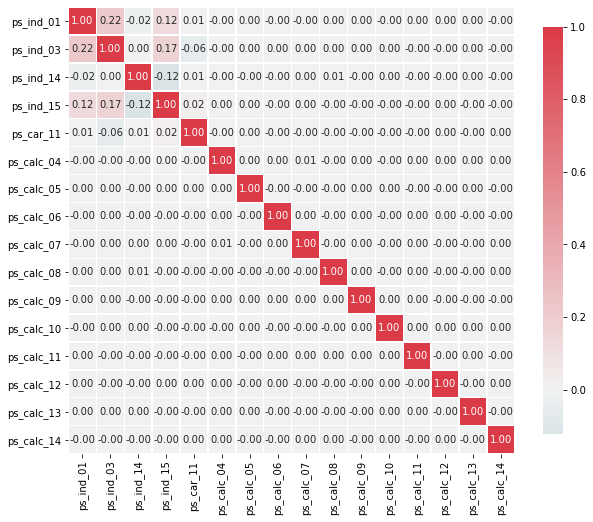

In [15]:
#Correlation heatmap between ordinal values

v = meta[(meta.level == 'ordinal') & (meta.keep)].index
corr_heatmap(v)

Challenges: I struggled greatly with a number of challenges in this project. My primary challenge was related to preprocessing. I wasn't used to working with a large amount of features at once. It was difficult to figure out how to organize the features for analysis and filling of missing values. It was also difficult to determine the best way to select the most important features to train the model with

Approach:  To begin, I one-hot(dummy) encoded categorical feature values. As seen below, the encoding drastically increased the number of features from 57 to 211. 

In [16]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index
print('Before dummification we have {} variables in train'.format(train.shape[1]))
train = pd.get_dummies(train, columns=v, drop_first=True)
print('After dummification we have {} variables in train'.format(train.shape[1]))

Before dummification we have 57 variables in train
After dummification we have 211 variables in train


Approach(Continued): Due to the relatively large number of features (211), it makes sense to try and select only the most important features to train the machine learning model in order to reduce the amount of computation and improve accuracy. A method shown in [4] suggested to remove features with low variance because these features have a low impact on the target variable. As seen below, using this method to remove features with a variance lower than 0.01 would allow me to eliminate 99 features. However, the variance threshold of 0.01 was arbitrarily selected. I am unsure how to properly select a variance threshold for this method of feature selection, so I chose not to use this method. 

In [19]:
#remove low variance variables?

from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=.01)
selector.fit(train.drop(['id', 'target'], axis=1)) # Fit to train without id and target variables

f = np.vectorize(lambda x : not x) # Function to toggle boolean array elements

v = train.drop(['id', 'target'], axis=1).columns[f(selector.get_support())]
print('{} variables have too low variance.'.format(len(v)))
print('These variables are {}'.format(list(v)))


99 variables have too low variance.
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_12', 'ps_car_14', 'ps_ind_05_cat_2', 'ps_ind_05_cat_5', 'ps_car_01_cat_1', 'ps_car_01_cat_2', 'ps_car_04_cat_3', 'ps_car_04_cat_4', 'ps_car_04_cat_5', 'ps_car_04_cat_6', 'ps_car_04_cat_7', 'ps_car_06_cat_2', 'ps_car_06_cat_5', 'ps_car_06_cat_8', 'ps_car_06_cat_12', 'ps_car_06_cat_16', 'ps_car_06_cat_17', 'ps_car_09_cat_4', 'ps_car_10_cat_1', 'ps_car_10_cat_2', 'ps_car_11_cat_2', 'ps_car_11_cat_3', 'ps_car_11_cat_4', 'ps_car_11_cat_6', 'ps_car_11_cat_7', 'ps_car_11_cat_8', 'ps_car_11_cat_9', 'ps_car_11_cat_13', 'ps_car_11_cat_14', 'ps_car_11_cat_15', 'ps_car_11_cat_17', 'ps_car_11_cat_18', 'ps_car_11_cat_19', 'ps_car_11_cat_20', 'ps_car_11_cat_21', 'ps_car_11_cat_23', 'ps_car_11_cat_24', 'ps_car_11_cat_25', 'ps_car_11_cat_26', 'ps_car_11_cat_29', 'ps_car_11_cat_30', 'ps_car_11_cat_31', 'ps_car_11_cat_33', 'ps_car_11_cat_34', 'ps_car_11_cat_35', 'ps_car_11_

Approach(Continued): Instead of using a variance threshold to select features, I chose to select features by importance values using a Random Forest Classifier. This method is detailed in [5]. I chose to reduce the number of features by 50% by selecting the features with the highest importance values from the random forest model. This reduced the total number of features from 209 to 105. 

In [20]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']

feat_labels = X_train.columns

rf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

rf.fit(X_train, y_train)
importances = rf.feature_importances_

indices = np.argsort(rf.feature_importances_)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]], importances[indices[f]]))

 1) ps_car_13                      0.047294
 2) ps_reg_03                      0.043475
 3) ps_car_14                      0.035460
 4) ps_calc_10                     0.032408
 5) ps_calc_14                     0.031869
 6) ps_calc_11                     0.030464
 7) ps_ind_15                      0.029463
 8) ps_ind_03                      0.029255
 9) ps_calc_02                     0.028120
10) ps_calc_01                     0.028116
11) ps_calc_03                     0.028038
12) ps_reg_02                      0.027883
13) ps_calc_13                     0.026347
14) ps_calc_08                     0.024962
15) ps_calc_07                     0.024899
16) ps_car_15                      0.023697
17) ps_calc_06                     0.023527
18) ps_calc_09                     0.022990
19) ps_reg_01                      0.022305
20) ps_ind_01                      0.022228
21) ps_calc_05                     0.021778
22) ps_calc_04                     0.021684
23) ps_calc_12                  

In [23]:
sfm = SelectFromModel(rf, threshold='median', prefit=True)
print('Number of features before selection: {}'.format(X_train.shape[1]))
n_features = sfm.transform(X_train).shape[1]
print('Number of features after selection: {}'.format(n_features))
selected_vars = list(feat_labels[sfm.get_support()])

train = train[selected_vars + ['target']] #Keep selected variables

X = train.drop('target', inplace=False, axis=1)
y = train['target']
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 2019)


Number of features before selection: 209
Number of features after selection: 105


Approach(continued): After pre-processing, 20% of the training set was split for a cross validation set. Since the proportion of holders who file an insurance claim (target = 1) is relatively low, stratified sampling was used to ensure that the cross validation set was a representitive sample. The hyperparameters for the xgboost classifier were tuned using the split training/cross validation sets. Hyperparameter values were iteratively tested and optimal parameters were selected based on maximizing GINI/ROC AUC score. 

The method of tuning hyperparameters was adapted from [7]. 

In [ ]:
#adapted from [6]
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert( len(actual) == len(pred) )  
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)  
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]  
    totalLosses = all[:,0].sum()  
    giniSum = all[:,0].cumsum().sum() / totalLosses  
  
    giniSum -= (len(actual) + 1) / 2  
    return giniSum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a) 

In [ ]:
#Tuning estimators and learning rate

n_estimators1 = [700,900,1200,1300]
learning_rate = [0.01,0.1,0.3]
gini_xgb1 = {}
for i in n_estimators1:
    for j in learning_rate:
        xgb_model = xgb.XGBClassifier(n_estimators = i, learning_rate=j, n_jobs=-1, tree_method = 'gpu_hist')
        xgb_model.fit(X_train, y_train)
        
        auc_xgb1[(i,j)] = roc_auc_score(y_cv, xgb_model.predict_proba(X_cv)[:,1])
        gini_xgb1[(i,j)] = gini_normalized(y_cv, xgb_model.predict_proba(X_cv)[:,1])

h = max(gini_xgb1, key=auc_xgb1.get)
print('Best Gini:', gini_xgb1[h])
print('Best AUC:', auc_xgb1[h])
print('Best Parameters:',h)
#Best Parameters = 1200,0.01

In [ ]:
#Tuning max_depth and subsample 

max_depth = [3,5,7,9]
subsample = [0.70,0.8,0.9]
auc_xgb2 = {}
gini_xgb2 = {}
for i in max_depth:
    for j in subsample:
        xgb_model = xgb.XGBClassifier(n_estimators = 1300, learning_rate=0.01, subsample= j, max_depth=i, n_jobs=-1, 
                                     tree_method = 'gpu_hist')
        xgb_model.fit(X_train, y_train)
        
        auc_xgb2[(1300,0.01,i,j)] = roc_auc_score(y_cv, xgb_model.predict_proba(X_cv)[:,1])
        gini_xgb2[(1300,0.01,i,j)] = gini_normalized(y_cv, xgb_model.predict_proba(X_cv)[:,1])

h = max(gini_xgb2, key=auc_xgb2.get)
print('Best Gini:', gini_xgb2[h])
print('Best AUC:', auc_xgb2[h])
print('Best Parameters:', h)
#Best Parameters = (1300, 0.01, 5, 0.9)

In [ ]:
auc_xgb3 = {}
gini_xgb3 = {}
n_estimators2 = [1250,1300,1350,1400,1450,1500]
for j in n_estimators2:
    xgb_model = xgb.XGBClassifier(n_estimators = j, learning_rate=0.01, subsample= 0.8, max_depth=5, n_jobs=-1,
                                 tree_method = 'gpu_hist')
    xgb_model.fit(X_train, y_train)

    auc_xgb3[(j,0.01,5,0.8)] = roc_auc_score(y_cv, xgb_model.predict_proba(X_cv)[:,1])
    gini_xgb3[(j,0.01,5,0.8)] = gini_normalized(y_cv, xgb_model.predict_proba(X_cv)[:,1])
    
h = max(gini_xgb3, key=auc_xgb3.get)
print('Best Gini:', gini_xgb3[h])
print('Best AUC:', auc_xgb3[h])
print('Best Parameters:', h)

#Best Parameters = (1400, 0.01, 5, 0.8)

In [ ]:
auc_xgb4 = {}
gini_xgb4 = {}
lambda_l1 = [0.8,0.9,1]
for j in lambda_l1:
    xgb_model = xgb.XGBClassifier(n_estimators = 1400, learning_rate=0.01, subsample= 0.8, max_depth=5, n_jobs=-1, reg_alpha=j,
                                 tree_method = 'gpu_hist')
    xgb_model.fit(X_train, y_train)

    auc_xgb4[(1400,0.01,5,0.8,j)] = roc_auc_score(y_cv, xgb_model.predict_proba(X_cv)[:,1])
    gini_xgb4[(1400,0.01,5,0.8,j)] = gini_normalized(y_cv, xgb_model.predict_proba(X_cv)[:,1])

h = max(gini_xgb4, key=auc_xgb4.get)
print('Best Gini:', gini_xgb4[h])
print('Best AUC:', auc_xgb4[h])
print('Best Parameters:', h)
#Best Parameters = (1400, 0.01, 5, 0.8, 1)

In [ ]:
auc_xgb5 = {}
gini_xgb5 = {}
min_child_weight = [98,99,100,101]
for j in min_child_weight:
    xgb_model = xgb.XGBClassifier(n_estimators = 1400, learning_rate=0.01, subsample= 0.8, max_depth=5, n_jobs=-1, reg_alpha=1,
                                 tree_method = 'gpu_hist', min_child_weight=j)
    xgb_model.fit(X_train, y_train)

    auc_xgb5[(1400,0.01,5,0.8,1,j)] = roc_auc_score(y_cv, xgb_model.predict_proba(X_cv)[:,1])
    gini_xgb5[(1400,0.01,5,0.8,1,j)] = gini_normalized(y_cv, xgb_model.predict_proba(X_cv)[:,1])

h = max(gini_xgb5, key=auc_xgb5.get)
print('Best Gini:', gini_xgb5[h])
print('Best AUC:', auc_xgb5[h])
print('Best Parameters:', h)

#Best Parameters = (1400, 0.01, 5, 0.8, 1, 100)

In [145]:
#xgboost classifier final parameters
xgb_params = {}
xgb_params['n_estimators'] = 1400
xgb_params['learning_rate'] = 0.01
xgb_params['max_depth'] = 5
xgb_params['feature_fraction'] = 1
xgb_params['min_child_weight'] = 100
xgb_params['reg_alpha'] = 1
xgb_params['subsample'] = 0.8

xgb_model = xgb.XGBClassifier(**xgb_params)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict_proba(X_cv)[:,1]

[01:42:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "feature_fraction" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:42:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [146]:
from sklearn.metrics import accuracy_score, confusion_matrix
print('\nAccuracy score: {}'.format((accuracy_score(np.around(xgb_pred).astype(int), y_cv))))
print('\nConfusion Matrix: \n{}'.format(confusion_matrix(np.around(xgb_pred).astype(int),y_cv)))


Accuracy score: 0.8999953904305338

Confusion Matrix: 
[[39048  4338]
 [    1     1]]


Evaluation: For cross validation, I evaluated accuracy score. The evaluation metric used in this competition is the Normalized Gini Coefficient. The Gini coeffecient sorts predictions from largest to smallest, and scores by comparing the cumulative proportion of positive class observations to a theoretical uniform proportion[2]. The Normalized Gini Coefficient is then obtained by normalizing the Gini coeffecient such that the maximum score is 1. It is difficult for me to understand the Gini coeffecient, but [8] gives a good intuitive explaination. I am unsure why Gini is the specific metric chosen for this competition.

My approach likely falls short in terms of estimation error because I chose to handle imbalanced classification by sampling the training data so that the proportion of records with insurance claim increased from 3.6% to 10%. This sampled set isn't representitive of the distribution of training set. Moreover, since the training set is sampled from an entire population, there's a possibility that the training set isn't representitive of the population distribution due to random varibility. 

Approximation error is limited in terms of how many estimators (1400) I selected. The algorithm starts with a single weak predictor and thus a large approximation error. As the number of rounds of boosting increases, the class of predictors grows which decreases approximation error. 

In [169]:
#GINI SCORE



gini_cv = gini_normalized(y_cv, xgb_pred)
print('Normalized GINI Score for Cross Validation: ', gini_cv)

Normalized GINI Score for Cross Validation:  0.29041810954498276


In addition to the above evaluation, the model was used to perform prediction on the test set and the predictions were submitted to kaggle. The submission recieved a private score of 0.27862 and a public score of 0.28157.

In [161]:
#Process and fit test data
data = []
for f in test.columns:
    # Defining the role
    if f == 'target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'
         
    # Defining the level
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f or f == 'id':
        level = 'nominal'
    elif test[f].dtype == float:
        level = 'interval'
    elif test[f].dtype == int or test[f].dtype == 'int64':
        level = 'ordinal'
#     else:
#         print(f)
        
    # Initialize keep to True for all variables except for id
    keep = True
    if f == 'id':
        keep = False
    
    # Defining the data type 
    dtype = test[f].dtype
    
    # Creating a Dict that contains all the metadata for the variable
    f_dict = {
        'varname': f,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    data.append(f_dict)
    
meta_test = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
meta_test.set_index('varname', inplace=True)

# Dropping the variables with too many missing values
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
test.drop(vars_to_drop, inplace=True, axis=1)
meta_test.loc[(vars_to_drop),'keep'] = False  # Updating the meta

# Imputing with the mean or mode
mean_imp = SimpleImputer(missing_values=-1, strategy='mean')
mode_imp = SimpleImputer(missing_values=-1, strategy='most_frequent')
test['ps_reg_03'] = mean_imp.fit_transform(test[['ps_reg_03']]).ravel()
test['ps_car_14'] = mean_imp.fit_transform(test[['ps_car_14']]).ravel()
test['ps_car_11'] = mode_imp.fit_transform(test[['ps_car_11']]).ravel()

#Dummy Encode
v = meta_test[(meta_test.level == 'nominal') & (meta_test.keep)].index
# print('Before dummification we have {} variables in test'.format(test.shape[1]))
test = pd.get_dummies(test, columns=v, drop_first=True)
# print('After dummification we have {} variables in test'.format(test.shape[1]))

test = test[selected_vars] #Keep selected variables
X_test = test

y_test_pred = xgb_model.predict_proba(test)#[:,1]


y_test_pred = xgb_model.predict_proba(X_test)[:,1]

#generate submission test file
submission = pd.DataFrame()
submission['id'] = test1['id']
submission['target'] = y_test_pred
submission.to_csv('final_predictions.csv', index = False)

In [162]:
summary = pd.DataFrame()
summary['Model'] = ['XGBoost']
summary['Public_Score'] = [0.27862]
summary['Private_Score'] = [0.28157]
summary

,Model,Public_Score,Private_Score
0,XGBoost,0.27862,0.28157


Evaluation Summary: The data was undersampled such that the proportion of records with insurance claims (target = 1) were 10% of all records. This was done to help the model learn the dataset because we are specifically interested classifying target = 1. Next, features with missing values were determined. Features with a very large amount of missing values were removed. Features with continuous data were imputed using either mean or mode. Missing categorical data values were left as -1.

Categorical values were dummy encoded. I noticed that ps_car_11 had 104 distinct values which I suspect may cause issues to the model because this one variable represents about half of the total features after encoding. However, I was unsure about how to recitify this. 

Correlation heatmaps were generated for numerical data and pair plots were generated for pairs of highly correlated variables. The proportions of customers with target = 1 were plotted for each categorical variable.

After one hot encoding, There were 211 total features. A random forest classifier was used to sort these features by importance value and the top 50% of features were selected. 

After processing, 20% of the training data was split for cross validation. This data was used to tune hyperparameters for the xgboost model, optimizing for maximum Normalized Gini Index score. Once the final hyperparameters were selected, the model was fit and validated with the cross validation set. This resulted in a accuracy score of 0.88 and a Normalized Gini score of 0.29.

The model was also used to generate predictions from the test set data. The predictions were submitted to kaggle and earned a public Normalized Gini score of 0.27862 and a private score of 0.28157

Overall, this approach seemed to work pretty well, but there were some limitations I observed. I was unsure how to handle ps_car_11 having such a large number of distinct values, so I chose to left it. This caused this one variable to represent a large proportion of the total number of features after one-hot encoding. Next, I arbitratily chose to reduce the number of features by 50%. I think a better approach would have been to look at the distribution of importance values and set a threshold based on that instead. Also, I selected important features using a random forest model. Since I ultimately used xgboost to fit the data, it might have made more sense to also use xgboost to select features. 

What I learned: I learned a lot more about EDA and visualization from this project. Since there were a large amount of features provided, and no insight was given into the real world meaning of the features, I had to rely more on analyzing/visualizing the data rather than using intuition. This project was also my first real attempt at feature selection. 

Citations: [1] https://www.kaggle.com/code/bertcarremans/data-preparation-exploration/notebook
[2] https://www.kaggle.com/competitions/porto-seguro-safe-driver-prediction/data
[3] https://www.kaggle.com/code/bertcarremans/reducing-number-of-numerical-features-with-pca/notebook
[4] https://www.analyticsvidhya.com/blog/2021/04/beginners-guide-to-low-variance-filter-and-its-implementation/
[5] https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch04/ch04.ipynb
[6] https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
[7] https://github.com/vysakh10/Porto_Seguro-s-Safe-Driver-Prediction/blob/master/Porto_Seguro_Final.ipynb
[8] https://www.kaggle.com/code/batzner/gini-coefficient-an-intuitive-explanation/notebook